In [5]:
from __future__ import print_function
from detdata import DetGen
import imgaug as ia
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from loss import FocalLoss
from torch.autograd import Variable
import matplotlib.pyplot as plt
from detdata.augmenters import crazy_augmenter
import numpy as np
from encoder import DataEncoder
from utils import box_nms
from retinanet import RetinaNet


In [3]:
# prepare generators

encoder = DataEncoder()

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

malaria_dataset = DetGen('/home/i008/malaria_data/dataset_train.mxrecords',
                         '/home/i008/malaria_data/dataset_train.csv',
                         '/home/i008/malaria_data/dataset_train.mxindex', batch_size=1)

malaria_dataset_generator = malaria_dataset.get_augmenting_generator(augmenter=crazy_augmenter)
malaria_dataset_generator_noaug = malaria_dataset.get_augmenting_generator(augmenter=None)


def create_retina_generator(malaria_dataset_generator=malaria_dataset_generator, pytorch_transformer=transformer):
    while True:
        batch_images, batch_bbs, batch_y = next(malaria_dataset_generator)
        batch_encoded_loc = []
        batch_encoded_label = []
        batch_torch_images = []
        for i, (image, bbs, y) in enumerate(zip(batch_images, batch_bbs, batch_y)):
            bbs_as_array = np.stack(list(map(lambda x: np.array([x.x1, x.y1, x.x2, x.y2]), bbs.bounding_boxes)))
            torch_bbs_as_array = torch.from_numpy(bbs_as_array).float()
            torch_y = torch.from_numpy(np.array(y).astype(int))
            loc_target, label_target = encoder.encode(torch_bbs_as_array, torch_y, (750, 750))
            batch_encoded_loc.append(loc_target)
            batch_encoded_label.append(label_target)
            image = pytorch_transformer(np.ascontiguousarray(image))
            batch_torch_images.append(image)

        yield torch.stack(batch_torch_images), torch.stack(batch_encoded_loc), torch.stack(
            batch_encoded_label), batch_images, batch_bbs


g = create_retina_generator()
g = create_retina_generator(malaria_dataset_generator_noaug)


In [7]:
# training

LOAD_CHECKPOINT = True

net = RetinaNet(num_classes=1)
if LOAD_CHECKPOINT:
    net.load_state_dict(torch.load('./checkpoint/retina_with_aug_2.pth'))

net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
net.cuda()

criterion = FocalLoss(num_classes=1)
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)


# Training
def train(epoch, generator):
    print('\nEpoch: %d' % epoch)
    net.train()
    net.module.freeze_bn()
    train_loss = 0
    for batch_idx, (inputs, loc_targets, cls_targets, real_images_batch, _) in enumerate(generator):
        inputs = Variable(inputs.cuda())
        loc_targets = Variable(loc_targets.cuda())
        cls_targets = Variable(cls_targets.cuda())
        try:
            optimizer.zero_grad()
            loc_preds, cls_preds = net(inputs)
            loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
            print('train_loss: %.3f | avg_loss: %.3f' % (loss.data[0], train_loss / (batch_idx + 1)))
        except Exception as e:
            print(e)
            print("batch failed")

# train(1)

(25, 4)


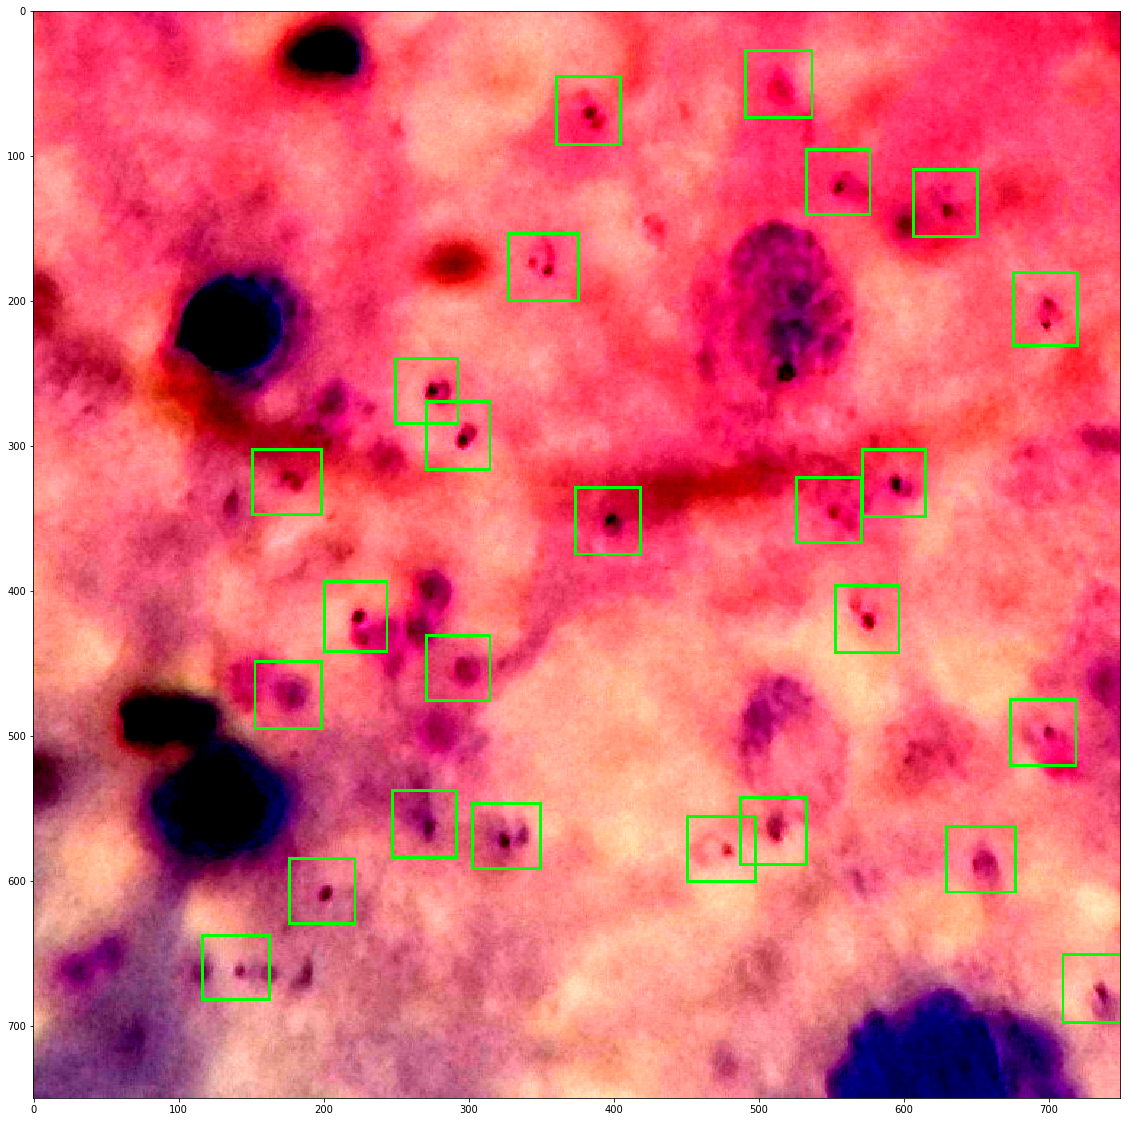

In [9]:
# inference

inputs, loc_targets, cls_targets, real_images_batch, _  = next(g)
inputs = Variable(inputs.cuda())
loc_targets = Variable(loc_targets.cuda())
cls_targets = Variable(cls_targets.cuda())
loc_preds, cls_preds = net(inputs)


# inputs, real_images, loc_preds, loc_targets, cls_preds, cls_targets = train(1)

loc_preds = loc_preds.data.squeeze()
cls_preds = cls_preds.data.squeeze()

input_size = torch.Tensor((750, 750))
anchor_boxes, _ = encoder._get_anchor_boxes(torch.Tensor((750, 750)))
loc_xy = loc_preds.cpu()[:, :2]
loc_wh = loc_preds.cpu()[:, 2:]
xy = loc_xy * anchor_boxes[:, 2:] + anchor_boxes[:, :2]
wh = loc_wh.exp() * anchor_boxes[:, 2:]
boxes = torch.cat([xy - wh / 2, xy + wh / 2], 1)  # [#anchors,4]
score = cls_preds.sigmoid().cpu()
ids = score > 0.3
ids = ids.cpu()
ids = ids.nonzero().squeeze()
keep = box_nms(boxes[ids], score[ids], threshold=0.5)
boxes = np.array(boxes[ids][keep])
print(boxes.shape)

IM = np.moveaxis(inputs.cpu().data.numpy()[0], 0, 2)
for box in boxes:
    bb = ia.BoundingBox(*box)
    IM = bb.draw_on_image(IM, thickness=2)

plt.figure(figsize=(20, 20))
plt.imshow(IM)


In [112]:
from __future__ import print_function

import os
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from loss import FocalLoss
from retinanet import RetinaNet
from datagen import ListDataset

from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
from detdata import DetGen
from detdata.augmenters import crazy_augmenter
import numpy as np
from encoder import DataEncoder
import imgaug as ia


from __future__ import print_function

import os
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from loss import FocalLoss
from retinanet import RetinaNet
from datagen import ListDataset

from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline



from detdata.augmenters import crazy_augmenter
import numpy as np
from encoder import DataEncoder
from utils import box_nms
from retinanet import RetinaNet



encoder = DataEncoder()


transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])


malaria_dataset = DetGen('/home/i008/malaria_data/dataset_train.mxrecords',
  '/home/i008/malaria_data/dataset_train.csv',
  '/home/i008/malaria_data/dataset_train.mxindex', batch_size=1)

malaria_dataset_generator = malaria_dataset.get_augmenting_generator(augmenter=crazy_augmenter) 
malaria_dataset_generator_noaug = malaria_dataset.get_augmenting_generator(augmenter=None) 


def create_retina_generator(malaria_dataset_generator=malaria_dataset_generator, pytorch_transformer=transformer):

    while True:
        batch_images, batch_bbs, batch_y = next(malaria_dataset_generator)
        batch_encoded_loc = []
        batch_encoded_label = []
        batch_torch_images = []
        for i, (image, bbs, y) in enumerate(zip(batch_images, batch_bbs, batch_y)):
            bbs_as_array = np.stack(list(map(lambda x: np.array([x.x1, x.y1, x.x2, x.y2]),  bbs.bounding_boxes))) 
            torch_bbs_as_array = torch.from_numpy(bbs_as_array).float()
            torch_y = torch.from_numpy(np.array(y).astype(int))
            loc_target, label_target = encoder.encode(torch_bbs_as_array, torch_y, (750, 750))
            batch_encoded_loc.append(loc_target)
            batch_encoded_label.append(label_target)
            image = pytorch_transformer(np.ascontiguousarray(image))
            batch_torch_images.append(image)
            
        
        yield torch.stack(batch_torch_images), torch.stack(batch_encoded_loc), torch.stack(batch_encoded_label), batch_images, batch_bbs

g = create_retina_generator()
g = create_retina_generator(malaria_dataset_generator_noaug)

In [113]:
# net = RetinaNet(num_classes=1)
# net.load_state_dict(torch.load('./checkpoint/retina_on_cls_OF.pth'))

# net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
# net.cuda()

criterion = FocalLoss(num_classes=1)
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    net.module.freeze_bn()
    train_loss = 0
    for batch_idx, (inputs, loc_targets, cls_targets, real_images_batch, _) in enumerate(g):
        inputs = Variable(inputs.cuda())
        loc_targets = Variable(loc_targets.cuda())
        cls_targets = Variable(cls_targets.cuda())
        try:
            optimizer.zero_grad()
            loc_preds, cls_preds = net(inputs)
            loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
            print('train_loss: %.3f | avg_loss: %.3f' % (loss.data[0], train_loss/(batch_idx+1)))
        except Exception as e:
            print(e)
            print("batch failed")
            
#         return inputs, real_images_batch, loc_preds, loc_targets, cls_preds, cls_targets


# train(1)


Epoch: 1
loc_loss: 0.017 | cls_loss: 0.233 | 

train_loss: 0.250 | avg_loss: 0.250


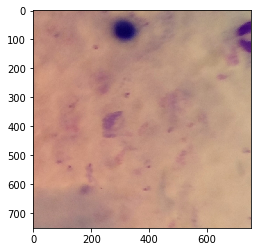

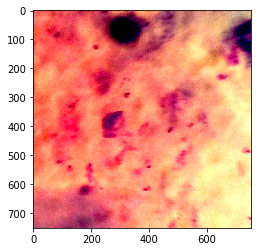

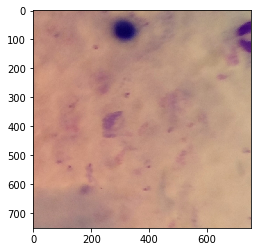

In [128]:
inputs, real_images, loc_preds, loc_targets, cls_preds, cls_targets = train(1)
# 
# M = torch.Tensor(((0.485,0.456,0.406)))
# S = torch.Tensor(((0.229,0.224,0.225)))
# inputs - torch.Tensor([])


# for i in range(1,3):
#     inputs[:,i,:,:] = inputs[:,i,:,:] * S[i-1]  + M[i-1]

# loc_targets

transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])

plt.imshow(np.moveaxis(transform(real_images[0]).numpy(), 0, 2))

plt.figure()
vx = np.moveaxis(inputs.cpu().data.numpy()[0], 0, 2)
plt.imshow(vx)

plt.figure()
plt.imshow(real_images[0])


(15, 4)


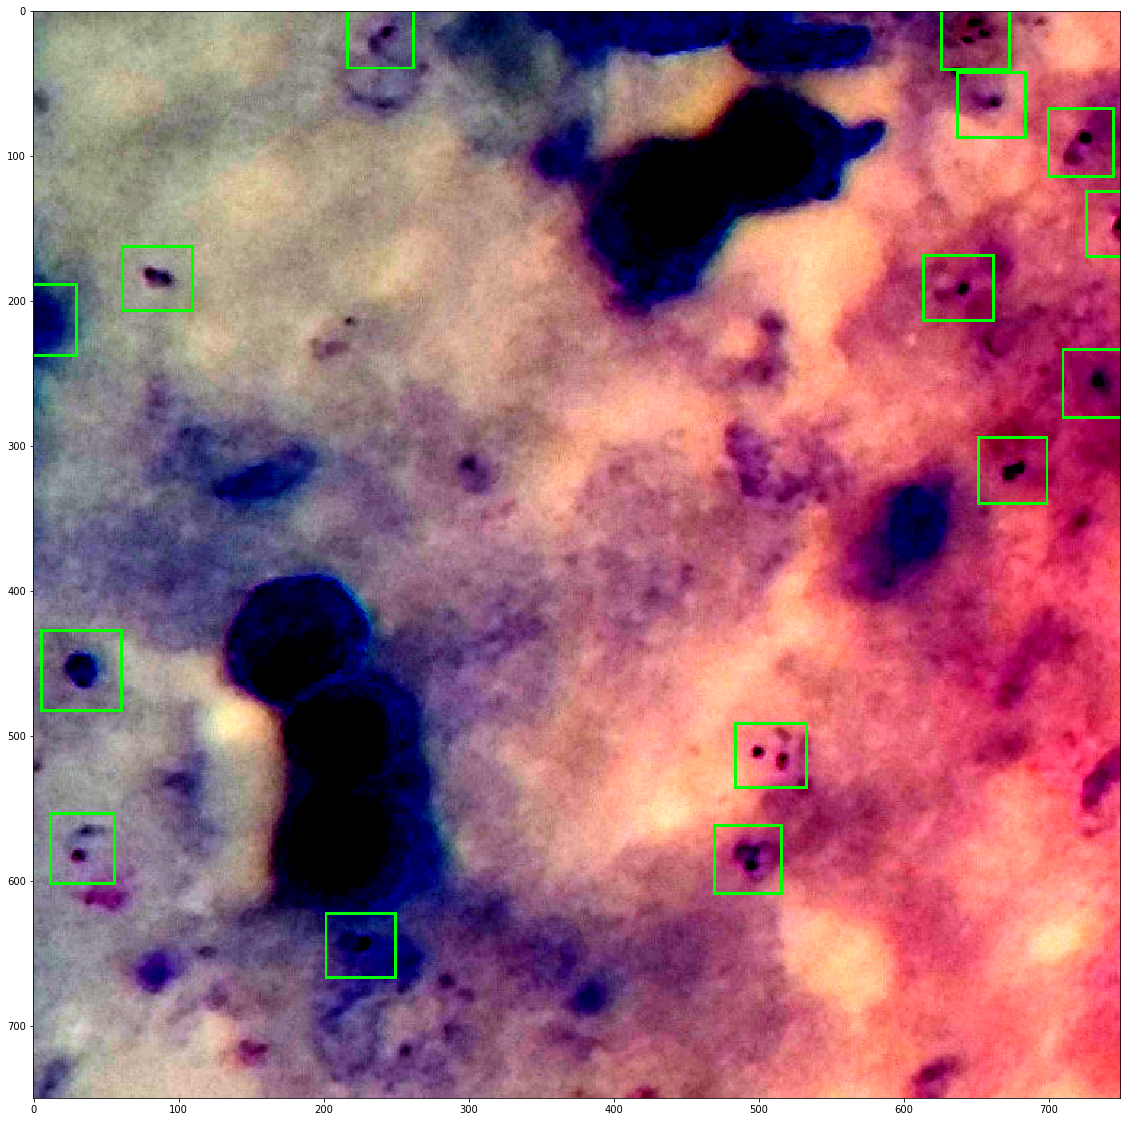

In [130]:

inputs, real_images, loc_preds, loc_targets, cls_preds, cls_targets = train(1)

loc_preds =loc_preds.data.squeeze()
cls_preds = cls_preds.data.squeeze()


input_size = torch.Tensor((750, 750))
anchor_boxes,_ = encoder._get_anchor_boxes(torch.Tensor((750,750)))
loc_xy = loc_preds.cpu()[:,:2]
loc_wh = loc_preds.cpu()[:,2:]
xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2]
wh = loc_wh.exp() * anchor_boxes[:,2:]
boxes = torch.cat([xy-wh/2, xy+wh/2], 1)  # [#anchors,4]
score = cls_preds.sigmoid().cpu()
ids = score > 0.2
ids = ids.cpu()
ids = ids.nonzero().squeeze()
keep = box_nms(boxes[ids], score[ids], threshold=0.1)
boxes = np.array(boxes[ids][keep])
print(boxes.shape)


IM = np.moveaxis(inputs.cpu().data.numpy()[0], 0, 2)
for box in boxes:
    bb = ia.BoundingBox(*box)
    IM= bb.draw_on_image(IM, thickness=2)
    
plt.figure(figsize=(20,20))
plt.imshow(IM)
